<a href="https://colab.research.google.com/github/hyyy11/colab0000/blob/main/17%EC%9D%BC%EC%B0%A8_0403.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

(60000, 28, 28) (10000, 28, 28)


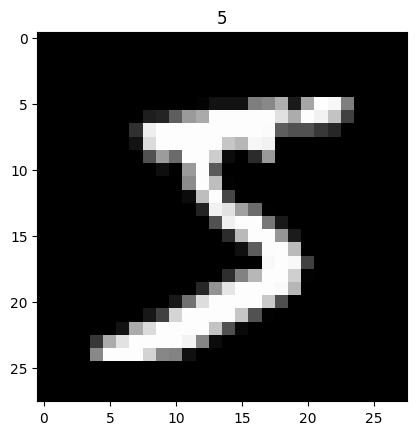

(60000, 784) (10000, 784)


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist

(x_train, t_train), (x_test, t_test) = mnist.load_data()     #MNIST 읽어 들이기
print(x_train.shape, x_test.shape)      #28*28의 손으로 쓴 문자 이미지가 6만 장

#각 픽셀의 값을 -1에서 1의 범위에 넣는다 
x_train = x_train / 255 * 2 -1
x_test = x_test / 255 * 2 -1

#손으로 쓴 문자 이미지의 표시
plt.imshow(x_train[0].reshape(28, 28), cmap="gray")
plt.title(t_train[0])
plt.show()

#1차원으로 변환한다
x_train = x_train.reshape(x_train.shape[0], -1)
x_test = x_test.reshape(x_test.shape[0], -1)
print(x_train.shape, x_test.shape)

In [8]:
n_learn = 20001   #학습 횟수
interval = 2000   #이미지를 생성하는 간격
batch_size = 32
n_noize = 128     #노이즈 수
img_size = 28     #생성되는 이미지의 높이와 폭
alpha = 0.2      #Leaky ReLU의 음의 영역에서 기울기

from tensorflow.python.keras.optimizers import adam_v2
optimizer = adam_v2.Adam(0.0002, 0.5)

In [9]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, LeakyReLU

#Generator의 망 구축
generator = Sequential()
generator.add(Dense(256, input_shape=(n_noize,)))
generator.add(LeakyReLU(alpha=alpha))
generator.add(Dense(512))
generator.add(LeakyReLU(alpha=alpha))
generator.add(Dense(1024))
generator.add(LeakyReLU(alpha=alpha))
generator.add(Dense(img_size**2, activation="tanh"))
print(generator.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               33024     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              525312    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 784)              

In [11]:
#Discriminator의 망 구축
discriminator = Sequential()
discriminator.add(Dense(512, input_shape=(img_size**2,)))
discriminator.add(LeakyReLU(alpha=alpha))
discriminator.add(Dense(256))
discriminator.add(LeakyReLU(alpha=alpha))
discriminator.add(Dense(1, activation="sigmoid"))
discriminator.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
print(discriminator.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
_________________________________________________________________
None


In [12]:
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Input

#결합 시는 Generator만 훈련한다
discriminator.trainable = False

#Generator에 의해 노이즈로부터 생성된 이미지를 Discriminator가 판정한다
noise = Input(shape=(n_noize,))
img = generator(noise)
reality = discriminator(img)

#Generator와 Discriminator의 결합
combined = Model(noise, reality)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)
print(combined.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128)]             0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 784)               1493520   
_________________________________________________________________
sequential_3 (Sequential)    (None, 1)                 533505    
Total params: 2,027,025
Trainable params: 1,493,520
Non-trainable params: 533,505
_________________________________________________________________
None


In [16]:
def generate_images(i):
    n_rows = 5     #행 수
    n_cols = 5     #열 수
    noise = np.random.normal(0, 1, (n_rows*n_cols, n_noize))
    g_imgs = generator.predict(noise)
    g_imgs = g_imgs/2 + 0.5     #0-1의 범위로 한다 

    matrix_image = np.zeros((img_size*n_rows, img_size*n_cols))      #전체 이미지

    #생성된 이미지를 나열해 1장의 이미지로 한다
    for r in range(n_rows):
        for c in range(n_cols):
            g_img = g_imgs[r*n_cols + c].reshape(img_size, img_size)
            matrix_image[r*img_size : (r+1)*img_size, c*img_size:(c+1)*img_size] = g_img

    plt.figure(figsize=(10, 10))
    plt.imshow(matrix_image, cmap="Greys_r")
    plt.tick_params(labelbottom=False, labelleft=False, bottom=False, left=False)      #축 눈금의 라벨과 선을 지운다
    plt.show  

n_learn: 0
loss_fake: 1.0361549854278564 acc_fake: 0.0
loss_real: 0.008315342478454113 acc_real: 1.0
loss_real: 0.008315342478454113 acc_real: 1.0
loss_comb: 0.5901088118553162
n_learn: 2000
loss_fake: 0.5029115676879883 acc_fake: 0.8125
loss_real: 0.6078943014144897 acc_real: 0.6875
loss_real: 0.6078943014144897 acc_real: 0.6875
loss_comb: 1.184049367904663
n_learn: 4000
loss_fake: 0.591770589351654 acc_fake: 0.8125
loss_real: 0.620160698890686 acc_real: 0.625
loss_real: 0.620160698890686 acc_real: 0.625
loss_comb: 0.8151660561561584
n_learn: 6000
loss_fake: 0.6613600254058838 acc_fake: 0.5625
loss_real: 0.586616039276123 acc_real: 0.625
loss_real: 0.586616039276123 acc_real: 0.625
loss_comb: 0.8654181957244873
n_learn: 8000
loss_fake: 0.5967970490455627 acc_fake: 0.8125
loss_real: 0.7198002338409424 acc_real: 0.6875
loss_real: 0.7198002338409424 acc_real: 0.6875
loss_comb: 0.9250036478042603
n_learn: 10000
loss_fake: 0.7651968002319336 acc_fake: 0.6875
loss_real: 0.6425741314888 acc_

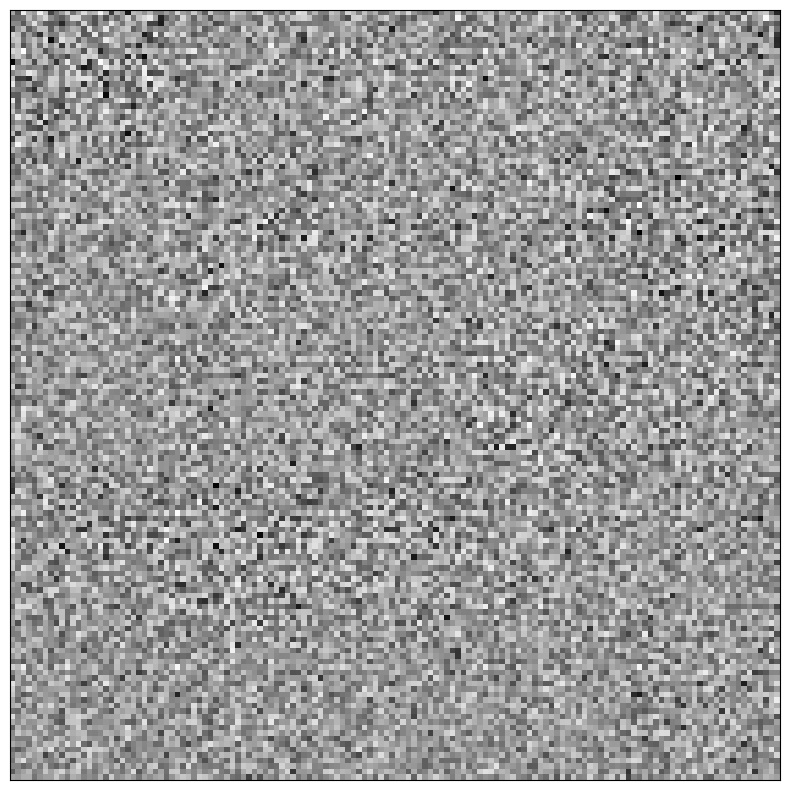

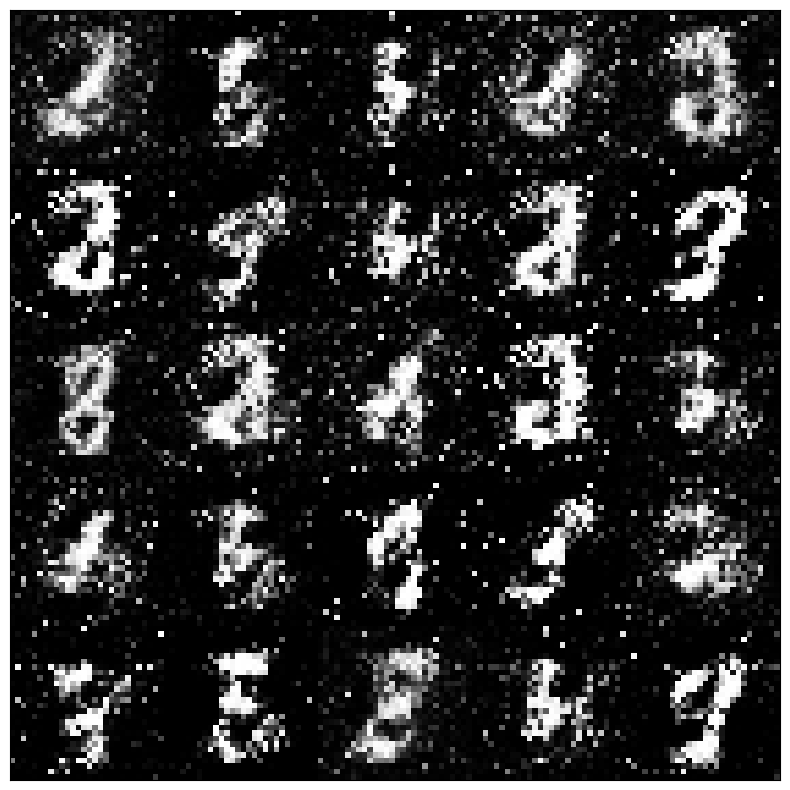

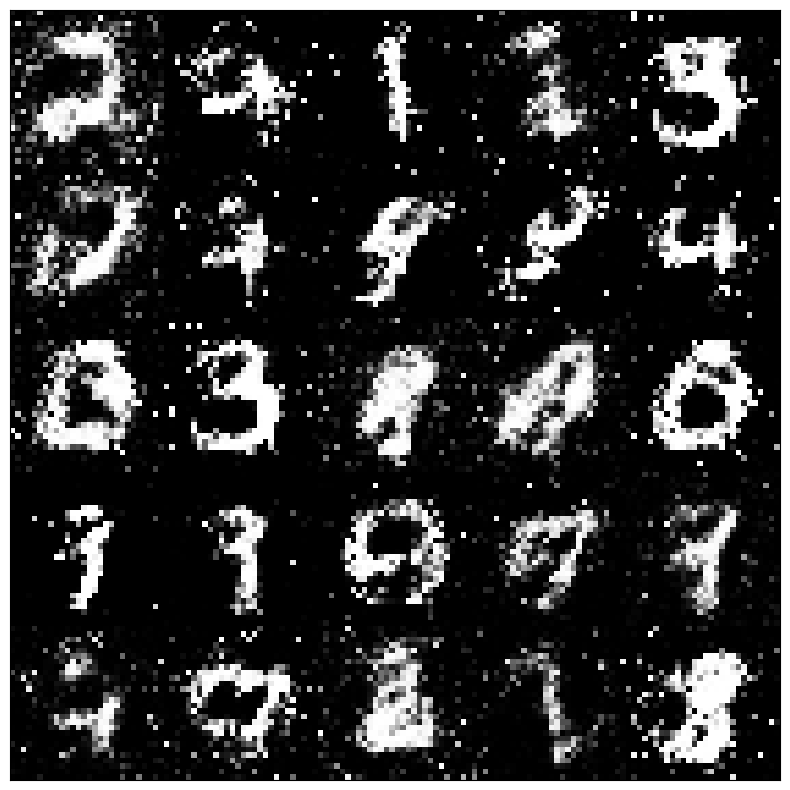

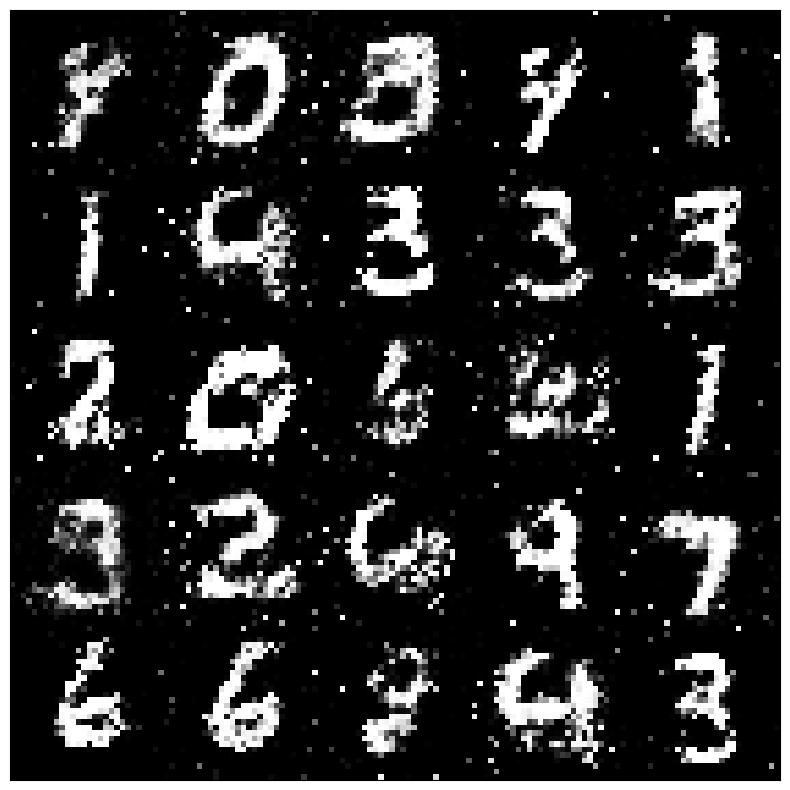

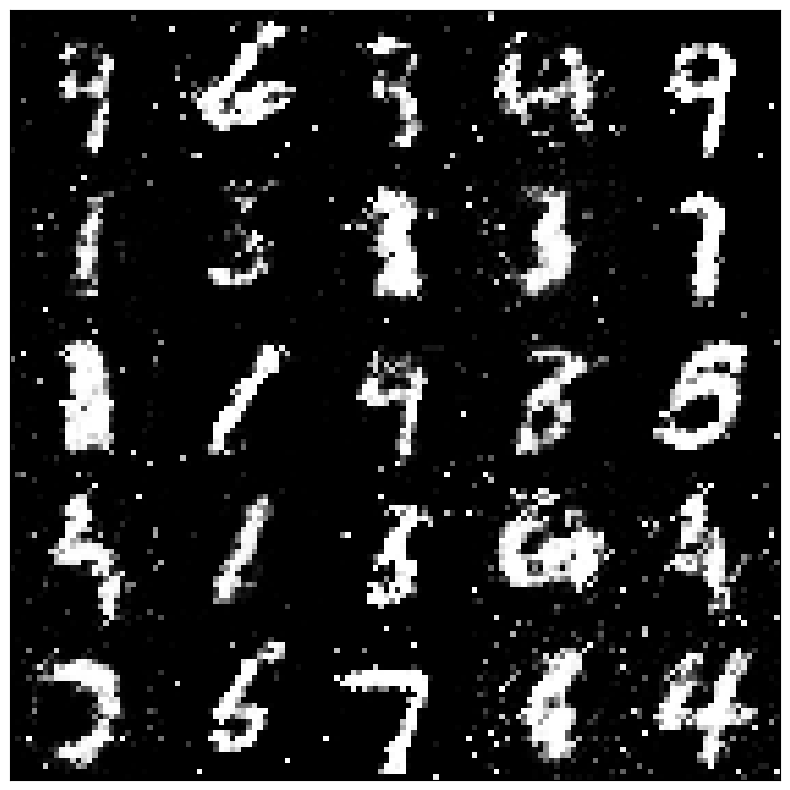

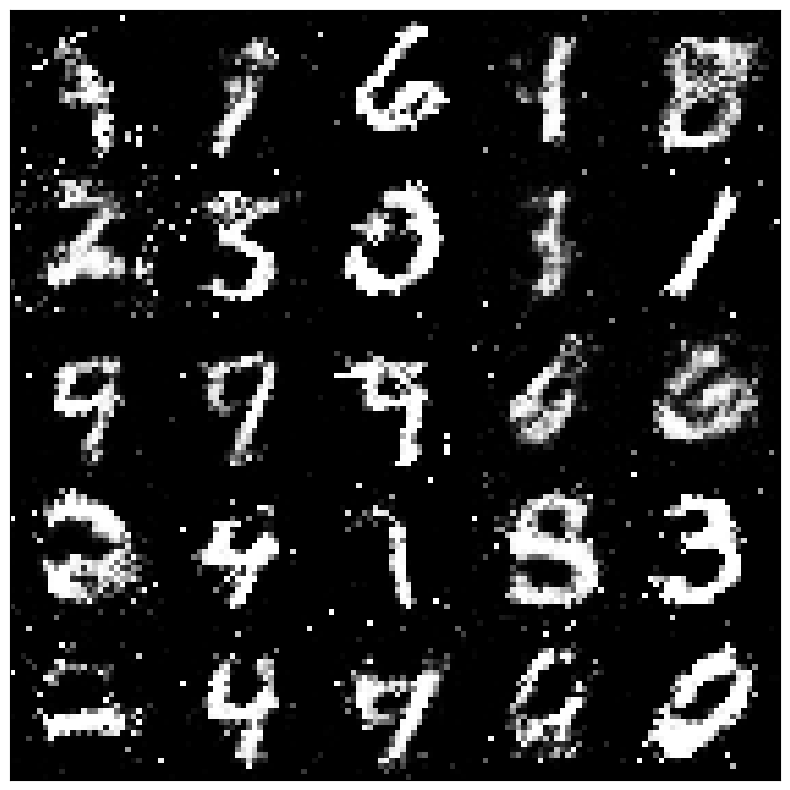

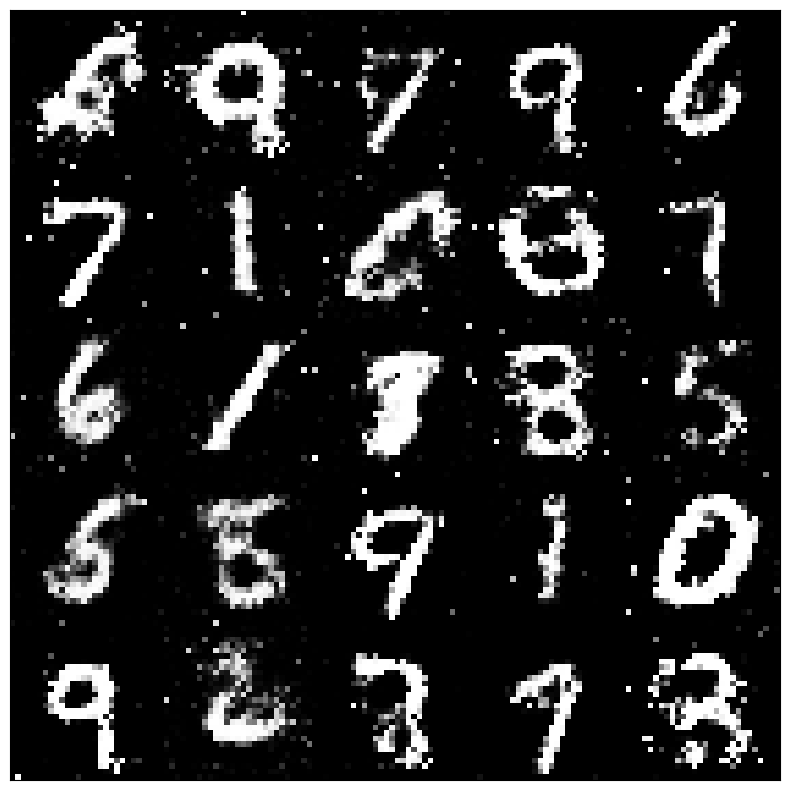

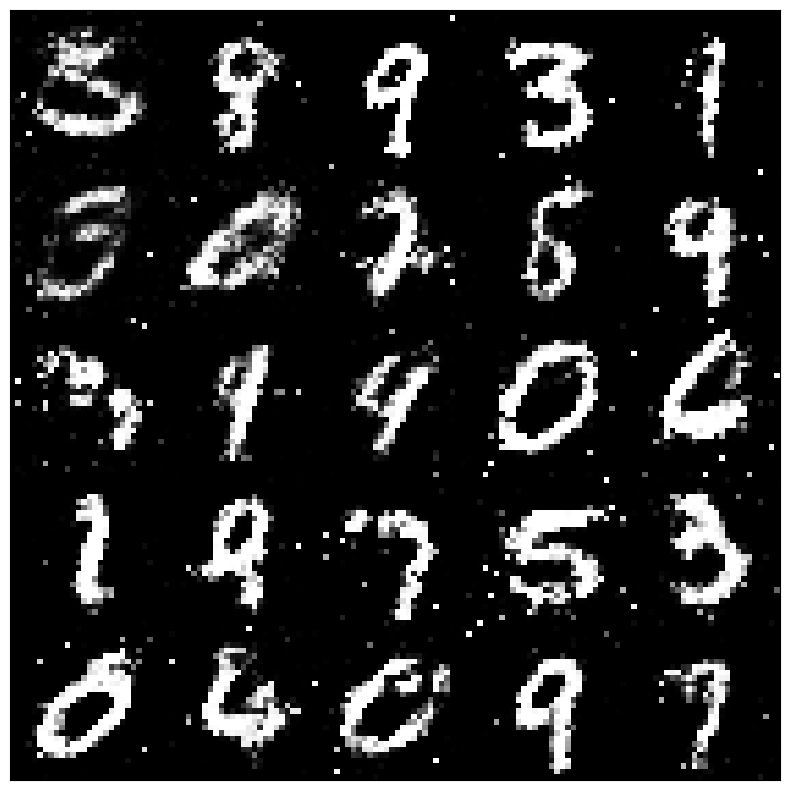

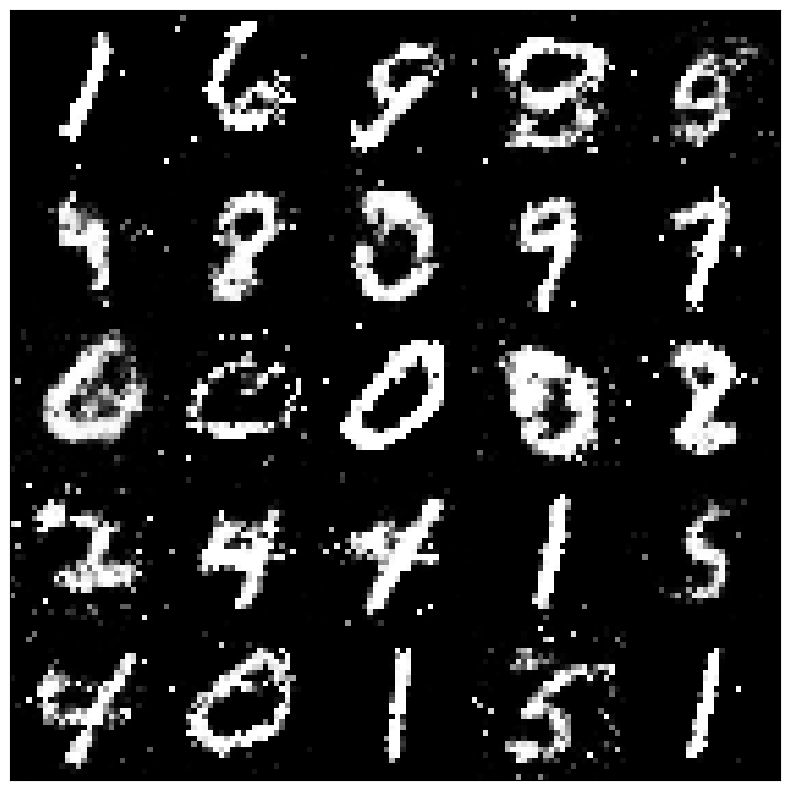

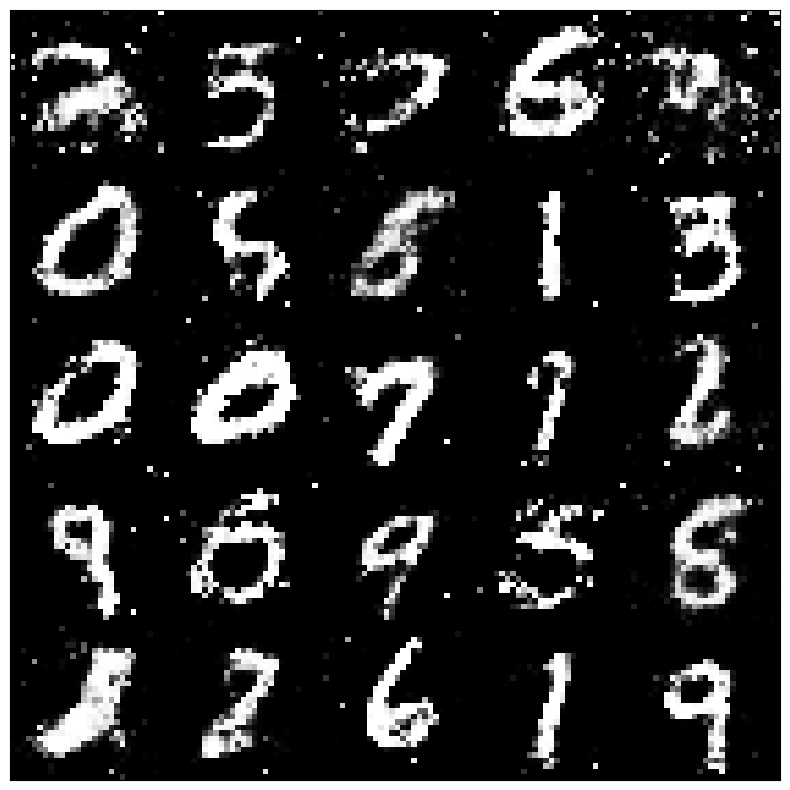

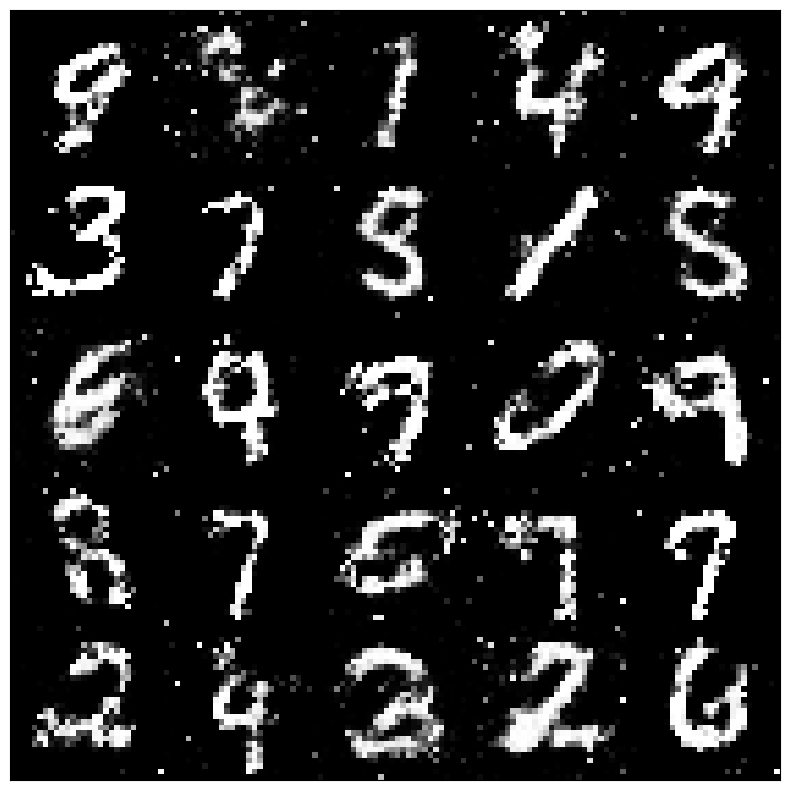

In [17]:
batch_half = batch_size // 2 

loss_record = np.zeros((n_learn, 3))
acc_record = np.zeros((n_learn, 2))

for i in range(n_learn):
    
    #노이즈로부터 이미지를 생성해 Discriminator를 훈련 
    g_noise = np.random.normal(0, 1, (batch_half, n_noize))
    g_imgs = generator.predict(g_noise)
    loss_fake, acc_fake = discriminator.train_on_batch(g_imgs, np.zeros((batch_half, 1)))
    loss_record[i][0] = loss_fake
    acc_record[i][0] = acc_fake

    #진짜 이미지를 사용해서 Discriminator를 훈련
    rand_ids = np.random.randint(len(x_train), size=batch_half)
    real_imgs = x_train[rand_ids, :]
    loss_real, acc_real = discriminator.train_on_batch(real_imgs, np.ones((batch_half, 1)))
    loss_record[i][1] = loss_real
    acc_record[i][1] = acc_real

    #결합한 모델에 의해 Generator를 훈련
    c_noise = np.random.normal(0, 1, (batch_size, n_noize))
    loss_comb = combined.train_on_batch(c_noise, np.ones((batch_size, 1)))
    loss_record[i][2] = loss_comb

    #일정 간격으로 생성된 이미지를 표시
    if i % interval == 0:
        print("n_learn:", i)
        print("loss_fake:", loss_fake, "acc_fake:", acc_fake)
        print("loss_real:", loss_real, "acc_real:", acc_real)
        print("loss_real:", loss_real, "acc_real:", acc_real)
        print("loss_comb:", loss_comb)

        generate_images(i)

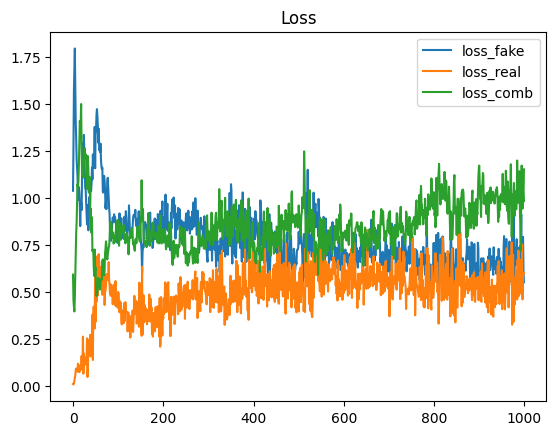

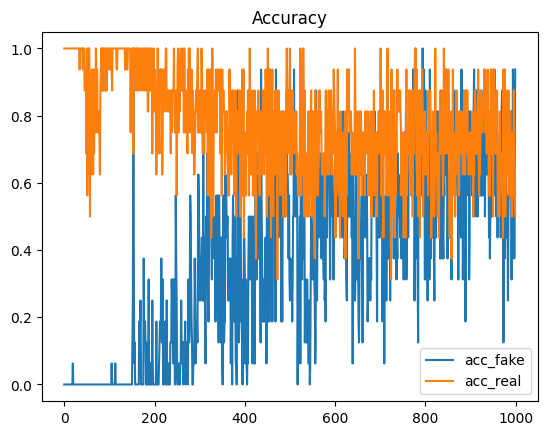

In [18]:
#오차의 추이
n_plt_loss = 1000     #오차의 표시 범위
plt.plot(np.arange(n_plt_loss), loss_record[:n_plt_loss, 0], label="loss_fake")
plt.plot(np.arange(n_plt_loss), loss_record[:n_plt_loss, 1], label="loss_real")
plt.plot(np.arange(n_plt_loss), loss_record[:n_plt_loss, 2], label="loss_comb")
plt.legend()
plt.title("Loss")
plt.show()

#정밀도의 추이
n_plt_acc = 1000    #정밀도의 범위 표시 범위
plt.plot(np.arange(n_plt_acc), acc_record[:n_plt_acc, 0], label="acc_fake")
plt.plot(np.arange(n_plt_acc), acc_record[:n_plt_acc, 1], label="acc_real")
plt.legend()
plt.title("Accuracy")
plt.show()